# **Machine Learning Group Project: Team 7**
# Project introduction

| Student Name | Student Number | Class Group |
| --- | --- | --- |
| **Alessandro Maugeri** | 53067 | TA |
| **Frank Andreas Bauer** | 53121 | TA |
|  **Johannes Rahn** | 53958 | TB |
| **Nicole Zoppi** | 53854 | TB |
| **Yannick von der Heyden** | 53629 | TA |



- **Course & Course Code:** Machine Learning (2487)
- **Instructors:** Qiwei Han & Alessandro Gambetti
- **Academic Year:** 2022/2023


This project was developed by Alessandro Alfio Maugeri, Frank Andreas Bauer, Johannes Rahn, Nicole Zoppi, and Yannick von der Heyden as part of Nova SBE's Machine Learning course taught during Semester 2 of the 2022/2023 academic year by Qiwei Han and Alessandro Gambetti. The purpose of the group work is to develop an end-to-end Machine Learning project with data of our choice, clearly highlighting the business use for our model.

The project exploits data from two distinct Kaggle pages ("Game Recommendations on Steam" and "Steam Store Games (Clean dataset)") which contain data on content published to the **Steam libary** (e.g. games and DLCs) and user-generated content associated with it (e.g. whether a review is positive or not, what general consensus is, how many people found the review useful, etc.). The final work merges data from 4 distinct CSV files and 1 JSON, all of which can be found in the data folder and all of whose contents are covered in detail in the current Notebook.

The objective is to develop a Machine Learning pipeline from beginning to end whose output has a clear, pertinent, and useful business use. In this project, we explore multiple models in order to identify the one which is best-suited for **predicting whether a given Steam user will enjoy a game or not**. This should allow Steam to optimize its service by tailoring it to individual clients and fine-tuning their recommender systems.

To guarantee a better computing perfomance, we split the project steps into 3 distinct Notebooks, meant to be run in succession. 

1. **a_csv_creation**. The current notebook presents the outline of the projects and reads data from the various datasets used, merging them into a final one (final_df) used for the following Notebooks.
2. **b_recommender_system**. The purpose of this notebook is to extract content-based similarities across different products on the basis of the plethora of of textual data contained in descriptive columns such as tags, genres, description, or steamspy_tags. These findings can later be utilized when building other models.
3. **c_data_exploration** TO ADD

---- 
Make sure to **only run this notebook once the previous notebooks [a_csv_creation.ipynb](a_csv_creation.ipynb) and [b_recommender_system.ipynb](b_recommender_system.ipynb) have been run at least once.** 

If those notebooks have both been run at least once, the kernel may be restarted before running this in order to obtain better performance and vaster machine memory.

## Importing Packages 

In [48]:
import ast
import csv
import datetime
import warnings
import scipy
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# From sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

from scipy.stats import chi2_contingency, pointbiserialr

## Reading DataFrame

In [2]:
# Optimizing datatypes for efficient DF storage
data_types = {
    'review_id': 'int32',
    'y': 'bool',
    'funny': 'int16',
    'helpful': 'int16',
    'app_id': 'int32',
    'title': 'string',
    'rating': 'category',
    'positive_ratio': 'int16',
    'user_reviews': 'int32',
    'win': 'bool',
    'mac': 'bool',
    'linux': 'bool',
    'price_final': 'float32',
    'price_original': 'float32',
    'discount': 'float32',
    'description': 'string',
    'tags': 'string',
    'english': 'int8',
    'developer': 'category',
    'publisher': 'category',
    'required_age': 'int8',
    'genres': 'string',
    'steamspy_tags': 'string',
    'achievements': 'int16',
    'average_playtime': 'int32',
    'median_playtime': 'int32',
    'owners': 'category',
    'steam_deck': 'bool',
    'user_id': 'int32',
    'products': 'int16',
    'reviews': 'int16',
    'hours': 'float32',
    'categories': 'string'
}

final_df = pd.read_csv('data/final_df.csv', dtype=data_types, parse_dates=['date', 'date_release'])
# Import the Similarity DataFrame
similarity_df = pd.read_csv("data/content_base.csv", index_col = "title")

In [3]:
# Rearrange Columns
final_df = final_df.reindex(columns = ["review_id", "y", "date", "funny", "helpful",
                                       "app_id", "title", "date_release", "rating", 
                                       "positive_ratio", "user_reviews", "win", "mac", "linux", 
                                       "price_final", "price_original", "discount", "description",
                                       "tags", 'english', 'developer', 'publisher', 'required_age', 
                                       'genres', 'steamspy_tags','achievements', 'average_playtime', 
                                       'median_playtime', "owners", "steam_deck",
                                       "user_id", "products", "reviews", "hours"])

# Sort by Review ID
final_df.sort_values(by=["review_id"], inplace = True)

In [4]:
similarity_df.head(3)

,Space Engineers,Minion Masters,Hearts of Iron IV,Clone Drone in the Danger Zone,Graveyard Keeper,The Sims™ 3,resident evil 4 (2005),Keep Talking and Nobody Explodes,Town of Salem,Sid Meier’s Civilization® VI,...,Atelier Totori ~The Adventurer of Arland~ DX,Resident Evil 7 Biohazard,Injustice™ 2,Tropico 6,Hot Dogs Horseshoes & Hand Grenades,Atelier Meruru ~The Apprentice of Arland~ DX,MONOPOLY® PLUS,Cuphead,Portal 2,Left 4 Dead
title,,,,,,,,,,,,,,,,,,,,,
Space Engineers,1.000000,0.334508,0.427098,0.457994,0.355432,0.319884,0.357162,0.312667,0.367464,0.336353,...,0.190142,0.321649,0.376031,0.417805,0.310957,0.189314,0.333536,0.320396,0.325330,0.388771
Minion Masters,0.334508,1.000000,0.429683,0.391744,0.162671,0.146910,0.191595,0.370716,0.466716,0.476283,...,0.140439,0.154929,0.418000,0.385688,0.174653,0.143216,0.366503,0.300582,0.221772,0.336051
Hearts of Iron IV,0.427098,0.429683,1.000000,0.318115,0.260223,0.333306,0.299160,0.327020,0.491988,0.661996,...,0.188563,0.228284,0.361223,0.538899,0.162382,0.183398,0.393657,0.314755,0.277435,0.320134


In [5]:
column_list = final_df.columns.tolist()
print(column_list)

['review_id', 'y', 'date', 'funny', 'helpful', 'app_id', 'title', 'date_release', 'rating', 'positive_ratio', 'user_reviews', 'win', 'mac', 'linux', 'price_final', 'price_original', 'discount', 'description', 'tags', 'english', 'developer', 'publisher', 'required_age', 'genres', 'steamspy_tags', 'achievements', 'average_playtime', 'median_playtime', 'owners', 'steam_deck', 'user_id', 'products', 'reviews', 'hours']


## Data Exploration

Having imported the final DataFrame, we explore its structure and data composition. Given that the textual variables have already served their purpose, we remove them from the dataframe.

In [6]:
final_df.drop(["tags", "genres", "steamspy_tags", "description"], 
              axis = 1, inplace = True)

#### Target Variable Exploration

First we explore the distribution of our target variable _y_, which is a column of booleans which signal whether a given user would recommend a given game or not.

In creating a countplot, we find that the dataset is rather unbalanced. Only 14.12% of observations is negative, while the remaining 85.88% is positive. This will certainly be kept in consideration when training our model, as the unbalance must be offset. With a quick calculation, we find that the ratio of positives to negatives is 6.08 approximately.

<Figure size 720x360 with 0 Axes>

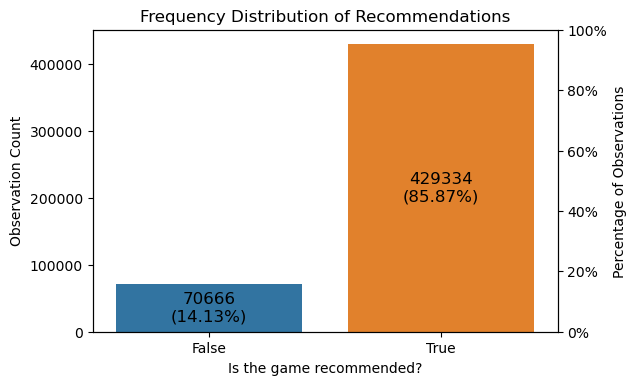

In [7]:
# Plotting the frequency distribution of number of recommendations
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)

ax = sns.countplot(x='y', data=final_df)

plt.title('Frequency Distribution of Recommendations')
plt.xlabel('Is the game recommended?')
plt.ylabel('Observation Count')

# Calculate percentage of each category
percentages = final_df['y'].value_counts(normalize=True) * 100

# Annotate the bars with counts and percentages
for p in ax.patches:
    count = int(p.get_height())
    percentage = percentages.sort_values()[int(p.get_x() + p.get_x())]
    ax.annotate(f'{count}\n({percentage:.2f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')

# Add percentage axis
ax2 = ax.twinx()
ax2.set_ylim(0, 100)
ax2.set_ylabel('Percentage of Observations')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

In [8]:
print("The \033[1mratio of positive to negative recommendations\033[0m is", 
     final_df['y'].value_counts()[0] / final_df['y'].value_counts()[1])

The ratio of positive to negative recommendations is 0.16459446491542715


In [9]:
column_names = final_df.columns.tolist()
print(column_names)

['review_id', 'y', 'date', 'funny', 'helpful', 'app_id', 'title', 'date_release', 'rating', 'positive_ratio', 'user_reviews', 'win', 'mac', 'linux', 'price_final', 'price_original', 'discount', 'english', 'developer', 'publisher', 'required_age', 'achievements', 'average_playtime', 'median_playtime', 'owners', 'steam_deck', 'user_id', 'products', 'reviews', 'hours']


#### Steam Rating Exploration

Reamining within the realm of ratings, we explore the distribution of the Steam rating system through a frequency table. Very interestingly, we observe that many of the rating categories are not in fact present in our data. It would seem that there are no games with overall negative reviews, while most games either have a _Very Positive_ or _Overwhelmingly Positive_ rating (appr. 86.24%). All in all, this is in line with the previous observation concerning the unbalanced dataset. 

Another noteworthy aspect of the dataset is that there are no _Positive_ reviews. The remaining 13.76% is split between _Mostly Positive_ and _Mixed_, with the former counting more observation than the latter. It is worth remembering that the Steam rating system assigns the _Positive_ rating to games that seem to have good ratings, but a review count which is not high enough to really "consacrate" its status as a very positively (or overwhlemingly positively) rated game. This perhaps informs us on the type of game which tends to be included in these datasets, focusing on larger more "mainstream" products rather than smaller lesser-known ones.

In [10]:
# Create a frequency table
rating_counts = pd.DataFrame(final_df['rating'].value_counts())

# Rename the columns
rating_counts.columns = ['Observation Count']

# Sort the rows based on the order of rating categories
rating_order = ["Overwhelmingly Positive", "Very Positive", "Positive", 
                "Mostly Positive", "Mixed", "Mostly Negative", 
                "Negative", "Very Negative", "Overwhelmingly Negative"]

rating_counts = rating_counts.reindex(rating_order)

# Fill NaN with 0
rating_counts.fillna(0, inplace = True)

# Add a column for percentage of observations
rating_counts['Percentage of Observations'] = rating_counts['Observation Count'] / len(final_df) * 100

# Format the percentage column
rating_counts['Percentage of Observations'] = rating_counts['Percentage of Observations'].map('{:.2f}%'.format)

# Turn to Integer
rating_counts["Observation Count"] = [int(i) for i in rating_counts["Observation Count"]]

display(rating_counts)

,Observation Count,Percentage of Observations
Overwhelmingly Positive,119265,23.85%
Very Positive,311922,62.38%
Positive,0,0.00%
Mostly Positive,57287,11.46%
Mixed,11526,2.31%
Mostly Negative,0,0.00%
Negative,0,0.00%
Very Negative,0,0.00%
Overwhelmingly Negative,0,0.00%


#### Owners Exploration

AAAAA

<Figure size 720x360 with 0 Axes>

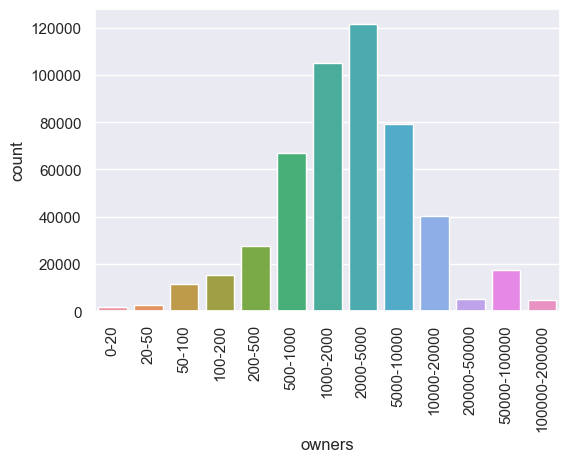

In [11]:
# Create Order
order_list = ["0-20", "20-50", "50-100", "100-200", "200-500", 
              "500-1000", "1000-2000", "2000-5000", "5000-10000", 
              "10000-20000", "20000-50000", "50000-100000", "100000-200000"]

# Plotting the frequency distribution of number of recommendations
sns.set_theme()
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.xticks(rotation=90)

ax = sns.countplot(x='owners', data=final_df,
                  order = order_list)

**Correlation Matrix**

C:\Users\utente\AppData\Local\Temp\ipykernel_3628\3189383655.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze['rating'] = df_analyze['rating'].map(rating_map)
C:\Users\utente\AppData\Local\Temp\ipykernel_3628\3189383655.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze['y'] = df_analyze['y'].map({True: 1, False: 0})


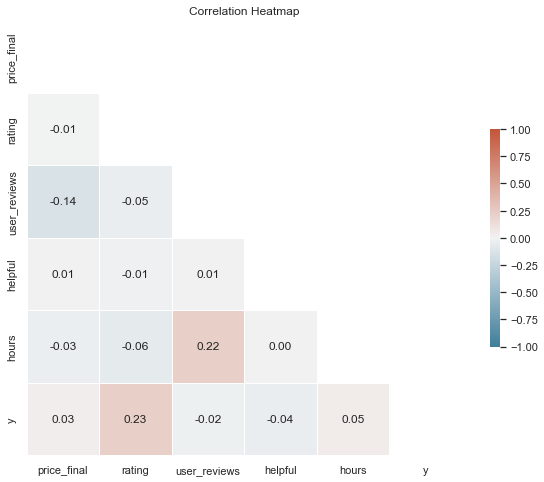

In [12]:
# correlations between different variables, such as price and rating, user reviews and helpful votes, or hours played and recommendation status.

df_analyze = final_df[['price_final', 'rating', 'user_reviews', 'helpful', 'hours', 'y']]

# Convert rating column to numerical values
rating_map = {'Overwhelmingly Positive': 5,
            'Very Positive': 4,
            'Mostly Positive': 3,
            'Mixed': 2,
            'Mostly Negative': 1,
            'Very Negative': 0}

df_analyze['rating'] = df_analyze['rating'].map(rating_map)

# Convert is_recommended column to binary values
df_analyze['y'] = df_analyze['y'].map({True: 1, False: 0})

# Calculate the correlation matrix
corr_matrix = df_analyze.corr()

# Setting seaborn style
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(10, 8))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


As expected, be observe the strongest positive correlations between y (recommendation status) and rating and user_reviews and hours. Hours and y (recommendation status) are also slightly correlated.
The final price seems to have a negative influence on user_reviews and the rating. 

The correlations will become usefull when building the models later and deciding what features to add to a model.

**Frequency Distribution of Final Prices**

By visualizing the distribution of final prices, we want to get a better understanding of the range of prices and how they are spread across different products. This helps us identify patterns, trends, and any skewness in the data. The frequency distribution plot also helps us to identify potential outliers or extreme values in the data. Outliers can significantly impact the performance of various statistical models and may require special handling or investigation.

<Figure size 720x360 with 0 Axes>

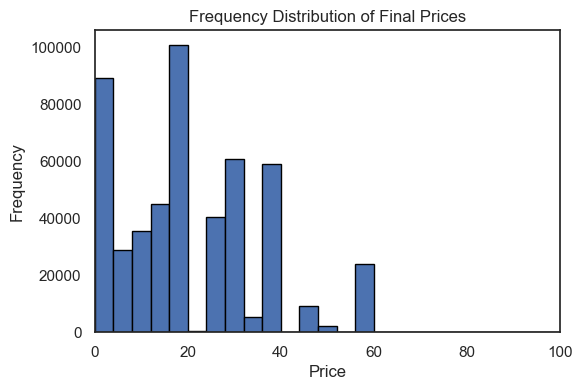

In [13]:
# frequency distribution of final prices

plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.hist(final_df['price_final'], bins=25, edgecolor='black', range=(0, 100))
plt.title('Frequency Distribution of Final Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()

The frequency distribution of final prices shows that most games are under 4.99, 19.99 and 59.99 dollars. 

We also see that there is no game beyond 60 euros.

Cheaper games in the price ranges from 0 to 20 euros dominate the in terms of frequency.


**Boxplot of Final Prices**

The Boxplot provides us with a visual summary of the distribution of the final prices in the dataset. It shows the median, lower quartile, upper quartile, and any potential outliers in the data. This helps us to understand the range and spread of the final prices, which can provide insights into pricing strategies or market conditions.

It also helps us to identify potential outliers in the data. Those outliers may indicate errors, unusual pricing patterns, or unique market conditions. Identifying these outliers can help you better understand the data and decide how to handle them in further analysis.

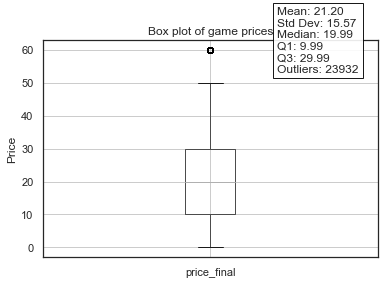

In [14]:
# boxplot of final price

ax = final_df.boxplot('price_final')

ax.set_ylabel('Price')
ax.set_title('Box plot of game prices')

stats = final_df['price_final'].describe()
mean = final_df['price_final'].mean()
std_dev = final_df['price_final'].std()

# calculate outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = final_df[(final_df['price_final'] < lower_bound) | (final_df['price_final'] > upper_bound)]['price_final']
num_outliers = outliers.count()

# add statistics to the plot
ax.text(0.7, 0.85, f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMedian: {stats['50%']:.2f}\nQ1: {stats['25%']:.2f}\nQ3: {stats['75%']:.2f}\nOutliers: {num_outliers}",
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))


plt.show()


The mean (average) of the data is 21.32, which means that the typical value in the dataset is around 21.32.
The median (middle value) is 19.99, which suggests that half of the data points are below 19.99 and half are above it. Since the mean and median are close to each other, this implies that the data distribution might be roughly symmetrical.

The standard deviation (Std. Dev.) is 16.95, indicating that the data points are spread out over a range of approximately 16.95 units from the mean. A larger standard deviation suggests greater variability in the dataset.

The first quartile (Q1) is 7.99, which means that 25% of the data points are below 7.99.
The third quartile (Q3) is 29.99, indicating that 75% of the data points are below 29.99.
The interquartile range (IQR), which represents the range of the middle 50% of the data, can be calculated as Q3 - Q1 = 29.99 - 7.99 = 22. This suggests that the middle 50% of the data points have a spread of 22 units.

There are no outliers in this dataset, which means that all data points fall within a reasonable range and there are no extreme values that could potentially skew the interpretation.

**Exploration of game developers**

In this section we explore the top 10 developers (number of games published and rating). It is important to note that developers can match or be different from publishers.

In [15]:
# Count the number of unique games released by each developer
developer_counts = final_df.groupby('developer')['title'].nunique()

# Sort the developers by the number of unique games in descending order and get the top 10
top_10_developers = developer_counts.sort_values(ascending=False).head(10)

# Print the top 10 developers
print(top_10_developers)

developer
Valve                         8
Bethesda Game Studios         6
KOEI TECMO GAMES CO., LTD.    6
Paradox Development Studio    4
Spike Chunsoft Co., Ltd.      4
CAPCOM Co., Ltd.              4
Capcom                        3
Obsidian Entertainment        3
Square Enix                   3
Treyarch                      3
Name: title, dtype: int64


In [16]:
unique_games = final_df['title'].nunique()
print(f"Number of unique games: {unique_games}")

Number of unique games: 305


In [17]:
unique_developers = final_df['developer'].nunique()
print(f"Number of unique developers: {unique_developers}")


Number of unique developers: 253


In [18]:
# Calculate the average positive rating for each developer
average_positive_ratings = final_df.groupby('developer')['positive_ratio'].mean()

# Sort the developers by the average positive rating in descending order and get the top 10
top_10_developers_positive_ratings = average_positive_ratings.sort_values(ascending=False).head(10)

# Print the top 10 developers with the best average positive ratings
print(top_10_developers_positive_ratings)


developer
Kristjan Skutta          98.0
ConcernedApe             98.0
Ludeon Studios           98.0
Re-Logic                 97.0
Matt Makes Games Inc.    97.0
Mega Crit Games          97.0
Nicalis, Inc.            97.0
Ninja Kiwi               97.0
Petroglyph               97.0
BeamNG                   97.0
Name: positive_ratio, dtype: float64


**Exploration of game publishers**

Similar to the developers, we also investigate the top 10 game publishers.

In [19]:
# Count the number of unique games released by each developer
publisher_counts = final_df.groupby('publisher')['title'].nunique()

# Sort the developers by the number of unique games in descending order and get the top 10
top_10_publishers = publisher_counts.sort_values(ascending=False).head(10)

# Print the top 10 developers
print(top_10_publishers)

publisher
Ubisoft                       11
Bethesda Softworks            10
Valve                         10
Spike Chunsoft Co., Ltd.       8
Paradox Interactive            8
SEGA                           8
BANDAI NAMCO Entertainment     6
KOEI TECMO GAMES CO., LTD.     6
Activision                     5
Square Enix                    5
Name: title, dtype: int64


In [20]:
unique_publishers = final_df['publisher'].nunique()
print(f"Number of unique publishers: {unique_publishers}")


Number of unique publishers: 198


**Relationship between Products Owned and Number of Reviews**

Looking at the relationship between products owned and the number of reviews can give insight into user engagement with a product. If a product has a high number of reviews relative to the number of products owned, it suggests that users are more actively engaged with the product and may have strong opinions about it. This also gives an indication about the popularity of a product. If a product has a high number of products owned but a low number of reviews, it may suggest that the product is popular but users are less likely to leave reviews.

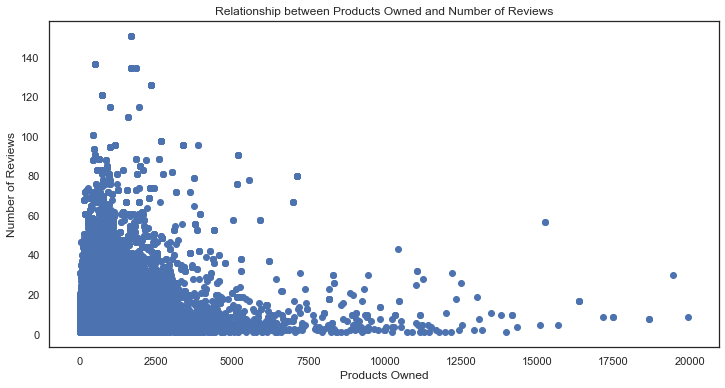

Correlation coefficient between Products Owned and Number of Reviews: 0.31


In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(final_df['products'], final_df['reviews'])
plt.xlabel('Products Owned')
plt.ylabel('Number of Reviews')
plt.title('Relationship between Products Owned and Number of Reviews')
plt.show()

correlation = final_df['products'].corr(final_df['reviews'])
print(f"Correlation coefficient between Products Owned and Number of Reviews: {correlation:.2f}")

The plot shows that users are more likely to leave a review when they own fewer products.

There could be a few reasons for this:

- Selection bias: People who own fewer products may be more passionate or invested in those products and therefore more likely to leave a review. They may have had a stronger emotional connection to the product or found it to be more impactful on their lives.
- Time constraints: People who own more products may have less time to leave a review for each product they own, whereas those who own fewer products may have more time to leave reviews.
- Product quality: People who own fewer products may be more discerning in their purchases and therefore more likely to leave a review to share their experience with others. They may also have higher expectations for the products they purchase, making them more likely to leave a review if the product meets or exceeds those expectations.
- Product type: It's possible that certain types of products, such as luxury items or niche products, are more likely to be reviewed by people who own fewer products. These products may be more novel or unique, leading to a higher likelihood of leaving a review.

**Compatibility of Windows, Mac and Linux**

Analyzing the compatibility between different operating systems helps us to understand the market distribution of each platform. Each operating system has a different market share, and understanding the distribution can inform developers about potential target audiences and which platforms are more popular among users. Different user groups may have preferences for specific platforms due to factors such as available software, hardware compatibility, or personal taste. Analyzing compatibility can also help to identify patterns or trends in user preferences and behavior across different platforms. In addition, compatibility data can provide insights into which platforms have higher demand or user base, helping developers make informed decisions.

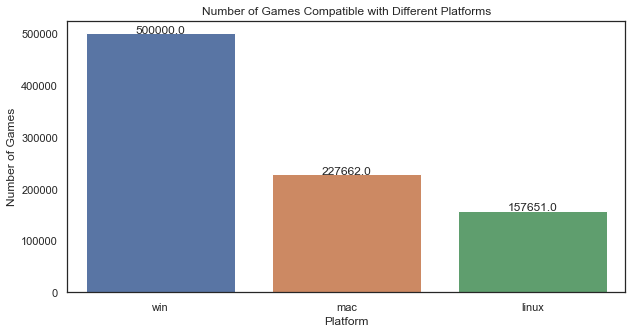

In [22]:
# compatibility with different platforms

# Calculating the number of games compatible with each platform
platform_counts = final_df[['win', 'mac', 'linux']].sum().reset_index()
platform_counts.columns = ['Platform', 'Count']

plt.figure(figsize=(10, 5))

ax = sns.barplot(x='Platform', y='Count', data=platform_counts)

plt.title('Number of Games Compatible with Different Platforms')
plt.xlabel('Platform')
plt.ylabel('Number of Games')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

In [23]:
# Calculate the number of games supporting each combination of platforms (windows, mac, linux)

win_only = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == False)).sum()
win_mac = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
win_linux = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()
win_mac_linux = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == True)).sum()
mac_only = ((final_df['win'] == False) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
linux_only = ((final_df['win'] == False) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()

print(f"Number of games supporting only Windows: {win_only}")
print(f"Number of games supporting Windows and Mac: {win_mac}")
print(f"Number of games supporting Windows and Linux: {win_linux}")
print(f"Number of games supporting Windows, Mac, and Linux: {win_mac_linux}")
print(f"Number of games supporting only Mac: {mac_only}")
print(f"Number of games supporting only Linux: {linux_only}")

Number of games supporting only Windows: 261857
Number of games supporting Windows and Mac: 80492
Number of games supporting Windows and Linux: 10481
Number of games supporting Windows, Mac, and Linux: 147170
Number of games supporting only Mac: 0
Number of games supporting only Linux: 0


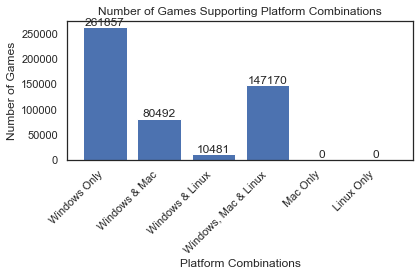

In [24]:
# Platform combinations and their counts

platform_combinations = {
    "Windows Only": win_only,
    "Windows & Mac": win_mac,
    "Windows & Linux": win_linux,
    "Windows, Mac & Linux": win_mac_linux,
    "Mac Only": mac_only,
    "Linux Only": linux_only,
}

fig, ax = plt.subplots()
ax.bar(platform_combinations.keys(), platform_combinations.values())

# Add the counts above the bars
for i, (combination, count) in enumerate(platform_combinations.items()):
    ax.text(i, count + 10, f"{count}", ha='center', va='bottom')

ax.set_title("Number of Games Supporting Platform Combinations")
ax.set_xlabel("Platform Combinations")
ax.set_ylabel("Number of Games")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Windows definitly dominates, when it comes to the number of games it supports. Most developers only develop for windows. However, there are still many games which run on windows, mac and linux. These results tell us that we should consider a users operating system, when recommending a game based on a user_id.

**Trends in game releases, user reviews, and ratings over time**

Analyzing these trends helps us to identify patterns in the gaming industry, such as seasonal variations in game releases and user reviews. Understanding these patterns can help stakeholders make informed decisions and tailor their strategies accordingly. Examining user ratings over time can help us to identify any patterns or changes in user sentiment which is important to understand if the general perception of a product or service is improving, declining, or remaining stable.

Moreover, looking at the user reviews and ratings over time can provide us with insights into how user preferences change and evolve. This information can be valuable for game developers and publishers to adjust their products and marketing efforts to meet user demands and expectations better.

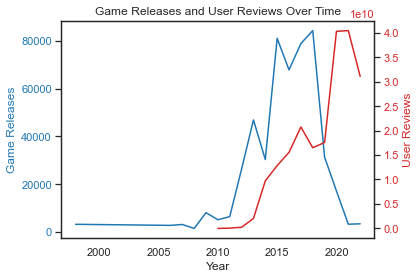

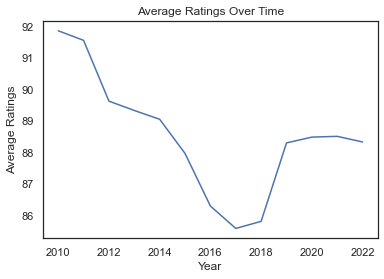

In [25]:
# Trends in game releases, user reviews, and ratings over time

final_df['date_release'] = pd.to_datetime(final_df['date_release'])
final_df['date'] = pd.to_datetime(final_df['date'])

game_releases_by_year = final_df.groupby(final_df['date_release'].dt.year).size()
user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].sum()
avg_ratings_by_year = final_df.groupby(final_df['date'].dt.year)['positive_ratio'].mean()

fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Game Releases', color='tab:blue')
ax1.plot(game_releases_by_year.index, game_releases_by_year, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('User Reviews', color='tab:red')
ax2.plot(user_reviews_by_year.index, user_reviews_by_year, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Game Releases and User Reviews Over Time')
plt.show()

plt.plot(avg_ratings_by_year.index, avg_ratings_by_year)
plt.xlabel('Year')
plt.ylabel('Average Ratings')
plt.title('Average Ratings Over Time')
plt.show()

On average, the number of game releases has increased from 2006 to 2022. There where several drop in 2013, 2018 and 2020. The last drop is most likely due to the Covid-19 pandemic. User started reviewing games since 2010. The number of reviews has strongly increased since then.

The average ratings over time have decreased from 93 in the year 2010 to 84 in 2018. Later it increased again to a rating of 84 in the year 2022. 

These results could be due to the following reasons:

Game Releases: The plot shows an increase in the number of game releases from 2006 to 2022. 
This could be attributed to several factors such as:
- Growing popularity of gaming: As gaming continues to gain popularity as a form of entertainment, more game developers are entering the market, leading to an increase in the number of game releases.
- Ease of developing and distributing games: With the rise of digital distribution platforms, it has become easier for game developers to develop and distribute games, which has led to an increase in the number of game releases.
- Advances in technology: The increasing availability of advanced game engines, tools, and resources has made it easier for game developers to create and release games.

User Reviews: The plot shows an increase in the number of user reviews since 2010. 
This could be attributed to several factors such as:
- Rise of online platforms: The rise of online platforms such as Steam, GOG, and Itch.io has made it easier for users to share their experiences and opinions on games.
- Social media: The increasing use of social media has made it easier for users to connect with each other and share their experiences with games, leading to an increase in user reviews.
- Importance of user feedback: Game developers have increasingly recognized the importance of user feedback in improving the quality of games, leading to an increase in the number of user reviews.

Average Ratings: The plot shows a decrease in average ratings from 2010 to 2018, followed by an increase in ratings from 2018 to 2022. 
This could be attributed to several factors such as:
- Increased competition: With more games being released every year, there is increased competition among game developers to produce high-quality games, which could have led to a decline in average ratings from 2010 to 2018.
- Changing user preferences: User preferences for games may have changed over time, leading to a decline in ratings for certain types of games.
- Increased focus on quality: Game developers may have focused more on improving the quality of their games in recent years, leading to an increase in average ratings from 2018 to 2022.

## Feature Engineering

In [26]:
def extra_features(X, add_elapsed = True):
    
    if add_elapsed:
        elapsed_time = X["date"] - X["date_release"]

### Creating New Features

**Rec System Input**

In [27]:
final_df

,review_id,y,date,funny,helpful,app_id,title,date_release,rating,positive_ratio,...,required_age,achievements,average_playtime,median_playtime,owners,steam_deck,user_id,products,reviews,hours
7825,41,True,2021-11-21,0,0,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,Very Positive,87,...,0,0,7504,2543,5000-10000,True,274890,256,7,166.6
31081,52,True,2021-02-13,0,0,289070,Sid Meier’s Civilization® VI,2016-10-20,Very Positive,84,...,0,241,3371,2390,2000-5000,True,226493,62,4,84.6
414231,61,True,2021-09-02,0,0,431960,Wallpaper Engine,2018-11-01,Overwhelmingly Positive,98,...,0,17,1731,542,5000-10000,True,438110,12,1,934.1
66280,112,False,2022-07-25,0,2,438100,VRChat,2017-02-01,Mostly Positive,71,...,0,0,1351,52,2000-5000,True,1140958,193,2,534.8
444222,176,False,2020-06-28,2,4,814380,Sekiro™: Shadows Die Twice - GOTY Edition,2019-03-21,Very Positive,94,...,18,34,2059,2212,2000-5000,True,3499793,82,14,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365176,10072210,True,2020-05-07,0,0,225540,Just Cause™ 3,2015-11-30,Very Positive,83,...,18,66,2086,438,2000-5000,True,3812515,57,1,59.6
183746,10072221,True,2018-12-22,0,0,225540,Just Cause™ 3,2015-11-30,Very Positive,83,...,18,66,2086,438,2000-5000,True,3148619,39,1,22.0
254064,10072247,True,2022-05-11,0,0,225540,Just Cause™ 3,2015-11-30,Very Positive,83,...,18,66,2086,438,2000-5000,True,574020,45,3,113.6
193445,10072261,True,2017-12-03,0,0,225540,Just Cause™ 3,2015-11-30,Very Positive,83,...,18,66,2086,438,2000-5000,True,2894100,195,12,29.2


**Elapsed Time:** A new feature which tracks the amount of time that has elapsed between the game's release and the review being logged. This could be interested because people who purchase a game right after its release are likely to be larger fans of the genre or franchise.

In [28]:
final_df["elapsed_time"] = final_df["date"] - final_df["date_release"]

# number of products with discount
# pertentage of products with discount

**Relative Recommendation:** Find the rate at which users rated a game positively (out of the count of games they have rated). Then, find for each review whether a recommendation is in line with user's typical reviews or not.

In [29]:
# Count the number of reviews per user and rename column
usr_rating_count = final_df[["user_id","y"]].groupby("user_id").count()
usr_rating_count.rename(columns = {"y":"review_count"}, inplace = True)

# Find the number of positive reviews
usr_rating_count["positive_reviews"] = final_df[["user_id","y"]].groupby("user_id").sum()

# Find how many reviews out of total are positive
usr_rating_count["positive_rate"] = usr_rating_count["positive_reviews"] / usr_rating_count["review_count"]

In [30]:
# Merge review_count and positive_rate to the final_df
final_df = final_df.merge(usr_rating_count.reset_index()[["user_id", "review_count", "positive_rate"]], 
                          how = "left", on = "user_id")

# Use these to create an ulterior feature with recommendation relative to average recommendation
final_df["relaitve_rec"] = (final_df["y"] - final_df["positive_rate"])

**Tendency to Review:** People who review more often tend to...

In [31]:
# Find Review Tendency 
final_df['review_tendency'] = np.divide(final_df['reviews'], final_df['products']).replace([np.inf, -np.inf], np.nan)

# Find Tendency Relative to Median Because of Low Values
final_df["rel_review_tendency"] = (final_df["review_tendency"] - final_df["review_tendency"].median())/ final_df["review_tendency"].median()

**Positive & Negative Reviews:** Here we calculate the number of positive and negative reviews for each game. This is done through the positive_ratio column.

In [32]:
final_df["positive_reviews"] = final_df["positive_ratio"] * final_df["user_reviews"]
final_df["negative_reviews"] = (1 - final_df["positive_ratio"]) * final_df["user_reviews"]

In [33]:
print(final_df.head(2))

   review_id     y       date  funny  helpful  app_id  \
0         41  True 2021-11-21      0        0  359550   
1         52  True 2021-02-13      0        0  289070   

                             title date_release         rating  \
0  Tom Clancy's Rainbow Six® Siege   2015-12-01  Very Positive   
1     Sid Meier’s Civilization® VI   2016-10-20  Very Positive   

   positive_ratio  ...  reviews  hours  elapsed_time  review_count  \
0              87  ...        7  166.6     2182 days             1   
1              84  ...        4   84.6     1577 days             1   

   positive_rate  relaitve_rec  review_tendency  rel_review_tendency  \
0            1.0           0.0         0.027344            -0.037500   
1            1.0           0.0         0.064516             1.270968   

  positive_reviews negative_reviews  
0         81779304        -80839312  
1         15330168        -15147666  

[2 rows x 38 columns]


**Comparison of mean playtime and median playtime in terms of skewness**

We compare mean and median playtime in terms of skewness to gain a better understanding of the distribution of the 'hours' column. This helps use to decide whether to use the mean or median for further analysis.

Number of outliers in 'hours' column: 40394
Skewness of 'hours' column: 1.5996909208126138
The 'hours' column is highly skewed. It is recommended to use the median for further analysis.


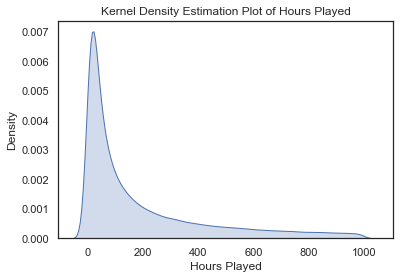

In [34]:
# skewness of the 'hours' column


# Step 1: Assess the distribution of the 'hours' column
skewness = final_df['hours'].skew()

# Step 2: Use a for loop to identify outliers (using the IQR method)
Q1 = final_df['hours'].quantile(0.25)
Q3 = final_df['hours'].quantile(0.75)
IQR = Q3 - Q1

outliers = []
for hours in final_df['hours']:
    if (hours < (Q1 - 1.5 * IQR)) or (hours > (Q3 + 1.5 * IQR)):
        outliers.append(hours)

# Print the number of outliers and skewness value
print(f"Number of outliers in 'hours' column: {len(outliers)}")
print(f"Skewness of 'hours' column: {skewness}")

# Step 3: Decide whether to use the median or the mean for further analysis
if skewness > 1 or skewness < -1:
    print("The 'hours' column is highly skewed. It is recommended to use the median for further analysis.")
else:
    print("The 'hours' column is not highly skewed. It is recommended to use the mean for further analysis.")


# Create a kernel density estimation plot for the 'hours' column
sns.kdeplot(final_df['hours'], shade=True)

# Add labels and title
plt.xlabel('Hours Played')
plt.ylabel('Density')
plt.title('Kernel Density Estimation Plot of Hours Played')

# Show the plot
plt.show()

There are 119,793 data points in the 'hours' column that are considered outliers, based on the Interquartile Range (IQR) method. These data points lie outside the typical range of values, and they might have a significant impact on the mean and standard deviation.

The 'hours' column is highly skewed - The skewness of the 'hours' column is either greater than 1, indicating that the distribution is not symmetric and has a significant tail on one side. In this case, the tail is likely on the right side, meaning that there are a few games with extremely high playtimes compared to the majority. 

Given these results, it is recommended to use the median instead of the mean for further analysis of the 'hours' column. The median is less sensitive to outliers and provides a more accurate representation of the central tendency of the data. By using the median, you can mitigate the impact of extreme values and better understand the typical playtime for games in the dataset.

## Additional Data Exploration after Feature Engeneering

**Exploration of elapsed time**

By analyzing the elapsed time, we can gain a better understanding about when users are most likely to write reviews, whether they tend to review games soon after release or after a significant amount of time has passed.

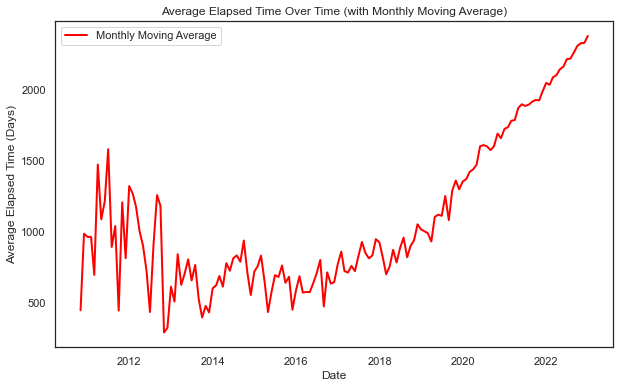

In [35]:
# Filter out rows with negative elapsed time
final_df = final_df[final_df['elapsed_time'].dt.days >= 0]

# Calculate the average 'elapsed_time_days' for each unique review date
average_elapsed_time = final_df.groupby('date')['elapsed_time'].mean().reset_index()

# Set the 'date' column as the index
average_elapsed_time.set_index('date', inplace=True)

# Convert the elapsed time to days
average_elapsed_time['elapsed_time'] = average_elapsed_time['elapsed_time'].dt.days

# Resample the data to a monthly frequency and calculate the moving average
monthly_moving_average = average_elapsed_time.resample('M').mean().rolling(window=1).mean()

# Plot the average 'elapsed_time_days' and the monthly moving average over time
plt.figure(figsize=(10, 6))
#plt.plot(average_elapsed_time, label='Average Elapsed Time (Days)')
plt.plot(monthly_moving_average, label='Monthly Moving Average', linewidth=2, color='red')
plt.xlabel('Date')
plt.ylabel('Average Elapsed Time (Days)')
plt.title('Average Elapsed Time Over Time (with Monthly Moving Average)')
plt.legend()
plt.show()


The plot shows that the average elapsed time increases on average from 2012 to 2022.

One possible reason for the increase in the average elapsed time over the years could be the increase in the number of games being released on the Steam platform over time.

As the number of games being released increases, the number of reviews being posted for each game is also likely to increase, leading to a larger number of reviews for games that have been released more recently. This, in turn, could lead to a higher average elapsed time for reviews, as more recent games would have less time for reviews to be posted compared to older games.

Additionally, as the number of games on the platform increases, the average age of games being reviewed is likely to decrease. Newer games are more likely to be reviewed closer to their release date than older games, which may also contribute to the increase in the average elapsed time for reviews.

In [36]:
unique_discounts = final_df['discount'].unique()
print(unique_discounts)

[ 0. 90. 75. 60. 50. 85. 80. 65. 66. 67. 84.]


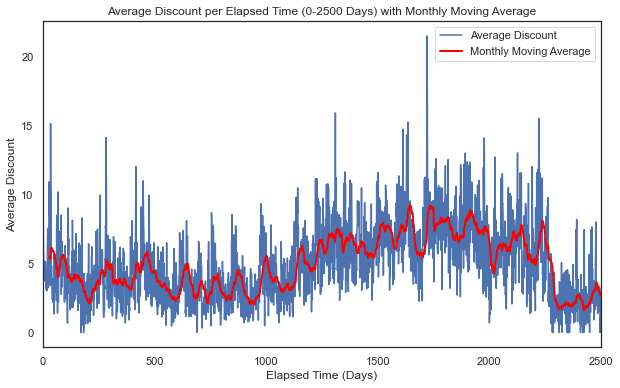

In [37]:
# Filter out rows with negative elapsed time and limit the range to 0-2500 days
final_df = final_df[(final_df['elapsed_time'].dt.days >= 0) & (final_df['elapsed_time'].dt.days <= 2500)]

# Convert the elapsed time to days
final_df['elapsed_time_days'] = final_df['elapsed_time'].dt.days

# Group by 'elapsed_time_days' and calculate the mean discount for each group
average_discount_per_elapsed_time = final_df.groupby('elapsed_time_days')['discount'].mean().reset_index()

# Set the 'elapsed_time_days' column as the index
average_discount_per_elapsed_time.set_index('elapsed_time_days', inplace=True)

# Calculate the moving average using a rolling window of approximately 30 days
monthly_moving_average = average_discount_per_elapsed_time.rolling(window=30).mean()

# Create the line plot with the monthly moving average
plt.figure(figsize=(10, 6))
plt.plot(average_discount_per_elapsed_time, label='Average Discount')
plt.plot(monthly_moving_average, label='Monthly Moving Average', linewidth=2, color='red')
plt.xlabel('Elapsed Time (Days)')
plt.ylabel('Average Discount')
plt.title('Average Discount per Elapsed Time (0-2500 Days) with Monthly Moving Average')
plt.xlim(0, 2500)
plt.legend()
plt.show()


The plot shows that as the elaplsed time increases, the average discount also increases. This is what we would have expected. However, from an elapsed time of 1300 days, the average discount is relatively stable.

**Exploration of review tendency**

In [38]:
print(final_df['review_tendency'].describe())
print("")
print(final_df['rel_review_tendency'].describe())

count    387676.000000
mean          0.054566
std           0.082278
min           0.000071
25%           0.012000
50%           0.027778
75%           0.062500
max           7.750000
Name: review_tendency, dtype: float64

count    387676.000000
mean          0.920731
std           2.896190
min          -0.997484
25%          -0.577600
50%          -0.022222
75%           1.200000
max         271.800000
Name: rel_review_tendency, dtype: float64


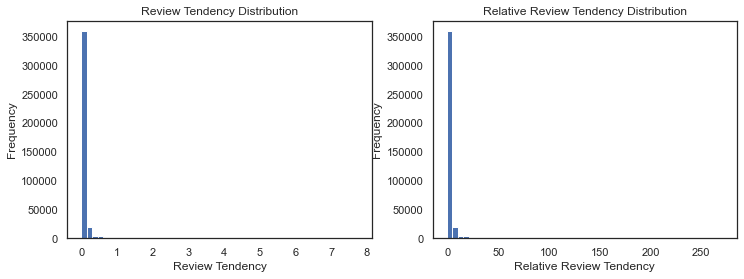

In [39]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Create a histogram of review_tendency variable in the first subplot
axes[0].hist(final_df["review_tendency"], bins=50)
axes[0].set_title("Review Tendency Distribution")
axes[0].set_xlabel("Review Tendency")
axes[0].set_ylabel("Frequency")

# Create a histogram of rel_review_tendency variable in the second subplot
axes[1].hist(final_df["rel_review_tendency"], bins=50)
axes[1].set_title("Relative Review Tendency Distribution")
axes[1].set_xlabel("Relative Review Tendency")
axes[1].set_ylabel("Frequency")

# Show the plots
plt.show()

The distribution of the variable review_tendency suggests that users tend to review a relatively small number of games. The mean value of 0.054 and the median value of 0.027 indicate that on average, users leave a review for only a small fraction of the games they own. Moreover, we need to take into account that every user recorded in the dataset has left at least one review. This suggests that the value of tendency to review calculated on the whole population would be considerely lower.

We can assume, as a consequence, that users only review games when they have a strong opinion about it. We check, then, if and how the tendency to review influences the review score.

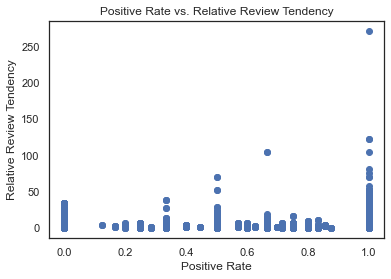

In [40]:
# Create a scatter plot of positive_rate vs rel_review_tendency
plt.scatter(final_df['positive_rate'], final_df['rel_review_tendency'])

# Set the title and axis labels
plt.title("Positive Rate vs. Relative Review Tendency")
plt.xlabel("Positive Rate")
plt.ylabel("Relative Review Tendency")

# Show the plot
plt.show()

NEED TO COMMENT ON THIS ONE

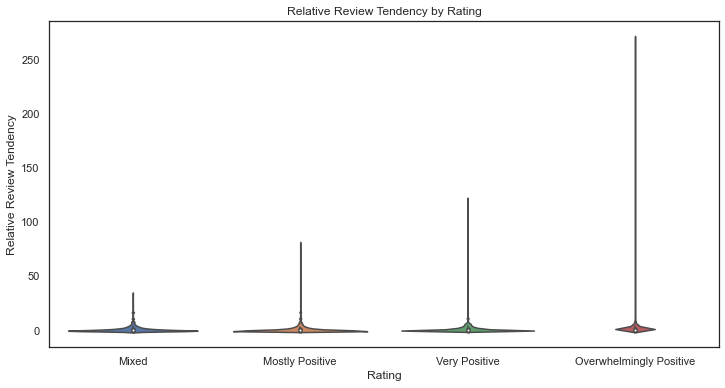

In [41]:
# Create a violin plot of review_tendency for each category of rating
plt.figure(figsize=(12,6))
ordered_categories = ['Mixed', 'Mostly Positive', 'Very Positive', 'Overwhelmingly Positive'] 
sns.violinplot(x="rating", y="rel_review_tendency", data=final_df, order=ordered_categories)

# Set the title and axis labels
plt.title("Relative Review Tendency by Rating")
plt.xlabel("Rating")
plt.ylabel("Relative Review Tendency")

# Show the plot
plt.show()

Comparing users' relative tendency to review to the rating they gave to the games, we notice how the higher is the tendency to review, the higher the scores given.

One possible explanation for this phenomenon is that users who are more active in reviewing games may have a stronger interest and engagement with the gaming community, and are therefore more likely to enjoy the games they play and give them higher ratings.

Alternatively, it could be that users who have a more positive overall attitude towards games are more likely to review them and give them higher ratings, while users who are more critical or have a negative bias may not review games as often or may be more likely to give lower ratings.

## Correlation
Since the variable 'y' is binary, and the dataset is composed of categorical, binary and continuous variable, we calculated the correlations with different coefficients.

In [42]:
final_df.dtypes

review_id                        int64
y                                 bool
date                    datetime64[ns]
funny                            int64
helpful                          int64
app_id                           int64
title                           object
date_release            datetime64[ns]
rating                          object
positive_ratio                   int64
user_reviews                     int64
win                               bool
mac                               bool
linux                             bool
price_final                    float64
price_original                 float64
discount                       float64
english                          int64
developer                       object
publisher                       object
required_age                     int64
achievements                     int64
average_playtime                 int64
median_playtime                  int64
owners                          object
steam_deck               

#### Continuous Variables
To calculate the correlation between "y" and continous variables, we use the point-biserial correlation coefficient. The point-biserial correlation coefficient measures the strength and direction of the association between a binary variable and a continuous variable.

The point-biserial correlation coefficient assumes that the binary variable is dichotomous, meaning it has only two possible values (in our case, 0 or 1), and that the continuous variable is normally distributed.

The point-biserial correlation is based on three assumptions: 
1. No outliers (continuous variable) - assessed through a visual examination of the scatterplot
2. Approximately normally distributed continuous variable
3. Homogeneity of variance of the continuous variable between both groups of the dichotomous variable

In [43]:
# Define the numeric variables
num_variables = ['price_final', 'positive_ratio', 'hours', 'median_playtime', 'user_reviews',
                'price_original', 'discount', 'products', 'reviews',
                'elapsed_time_days', 'review_count']

Check that the variables meet the requirements for the point-biserial correlation.

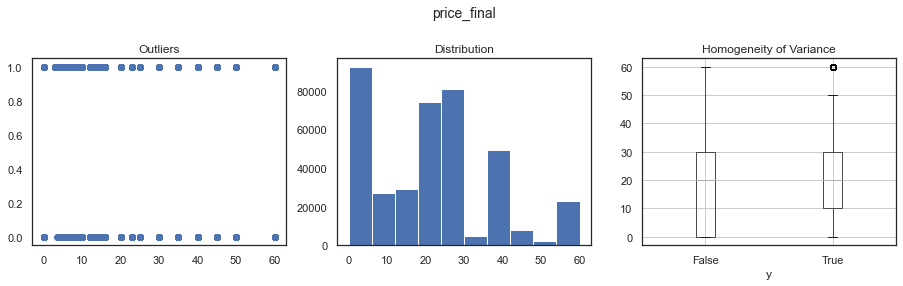

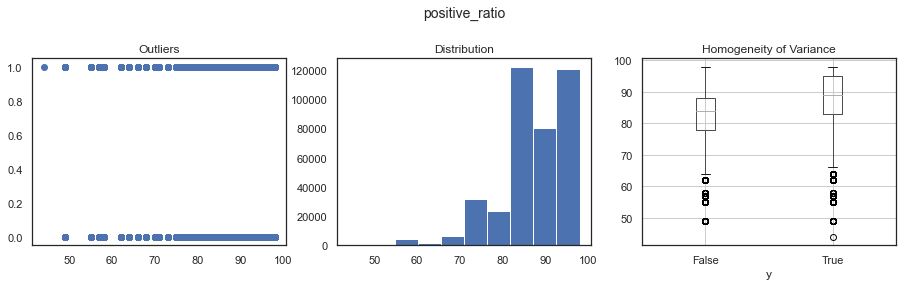

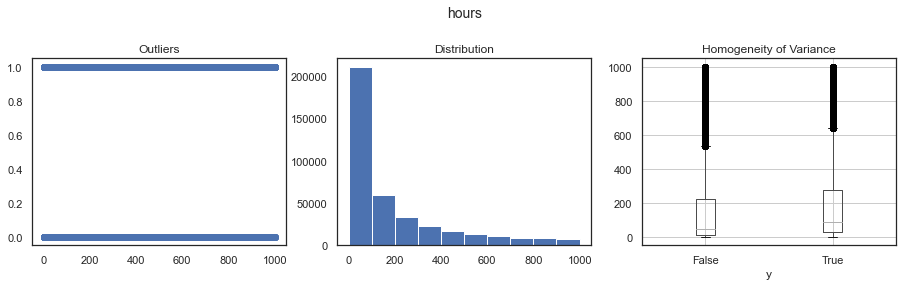

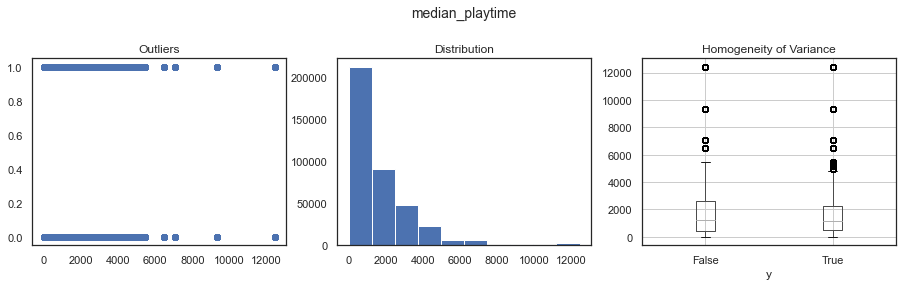

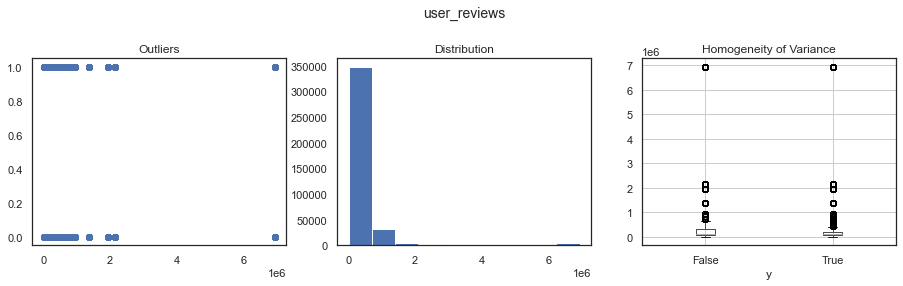

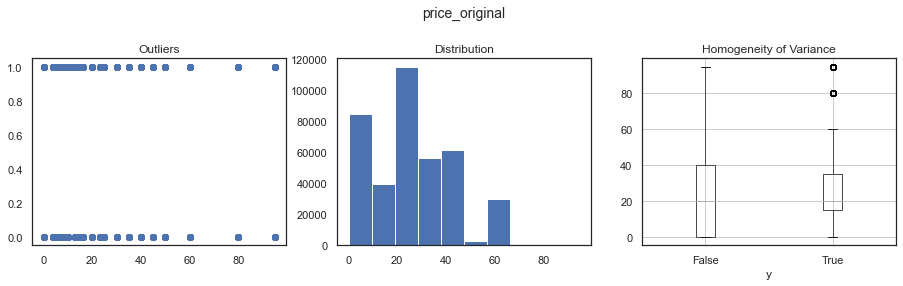

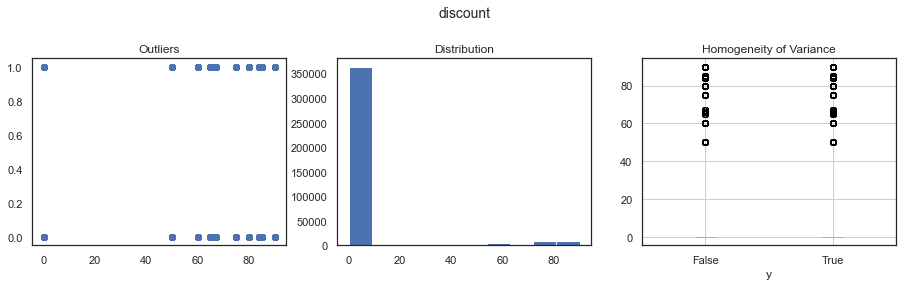

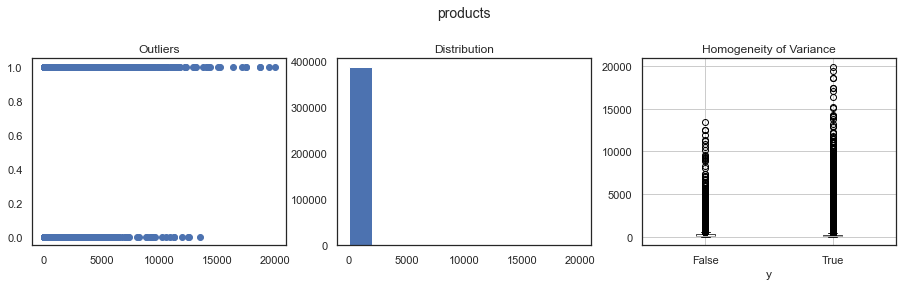

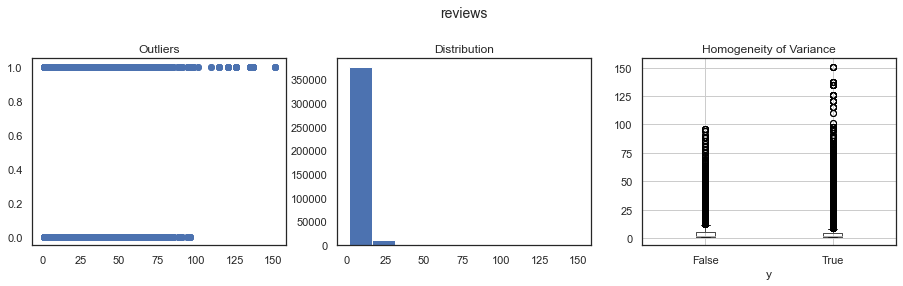

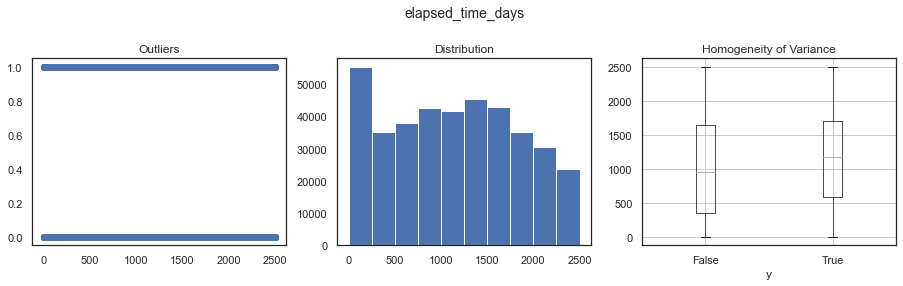

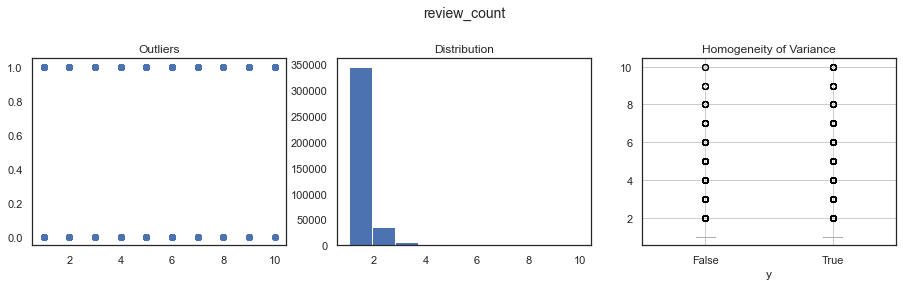

In [44]:
# loop through the numeric variables
def check_req(df, variable_list):
    for var in variable_list:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        # Check for outliers with a scatterplot
        axs[0].scatter(df[var], final_df['y'])
        axs[0].set_title("Outliers")

        # Check for normal distribution with a histogram
        axs[1].hist(df[var])
        axs[1].set_title("Distribution")

        # Check for homogeneity of variance with a boxplot
        df.boxplot(column=var, by='y', ax=axs[2])
        axs[2].set_title("Homogeneity of Variance")

        # Set overall title
        plt.suptitle(var, fontsize=14)
        fig.subplots_adjust(top=0.8)

        plt.show()
        
check_req(final_df, num_variables)

In [45]:
# Create a new DataFrame to store the normalized variables
final_df_log = pd.DataFrame()

var_to_norm = ['hours', 'median_playtime', 'user_reviews',
                'products', 'reviews',
                'elapsed_time_days', 'review_count']

# Loop over the variables and apply log transformation to each one
for col in var_to_norm:
    final_df_log[col] = np.log(final_df[col] + 0.0001)
    
final_df_norm = pd.concat([final_df.drop(var_to_norm, axis=1), final_df_log], axis=1)

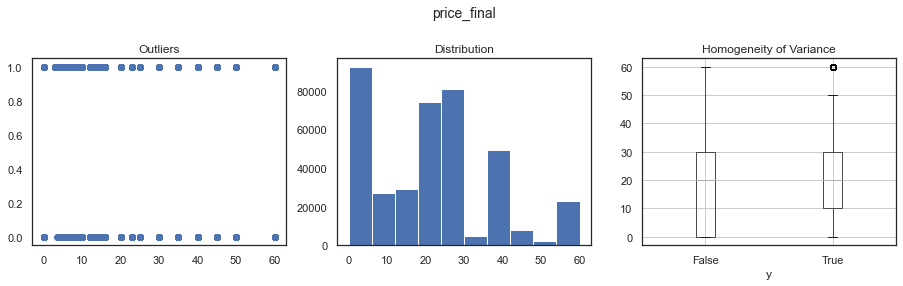

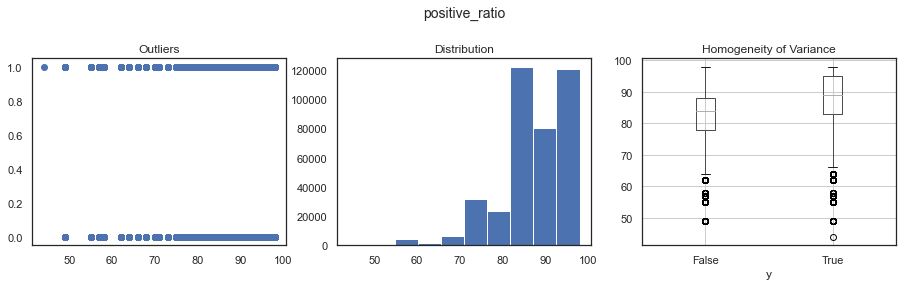

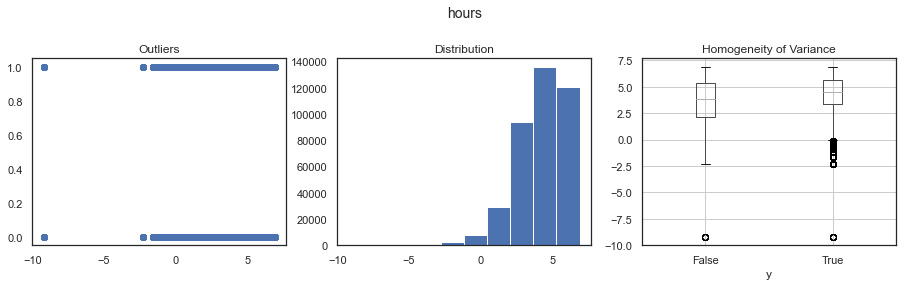

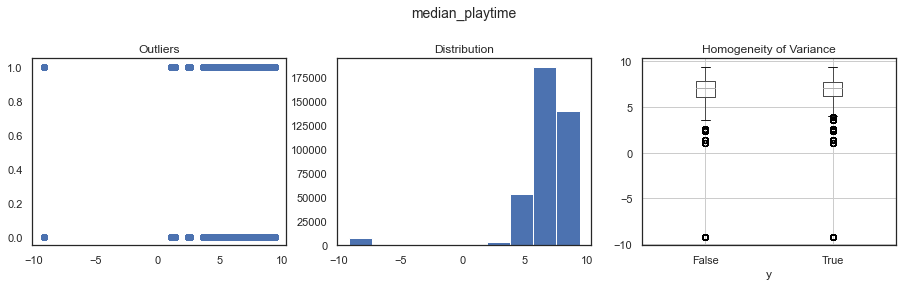

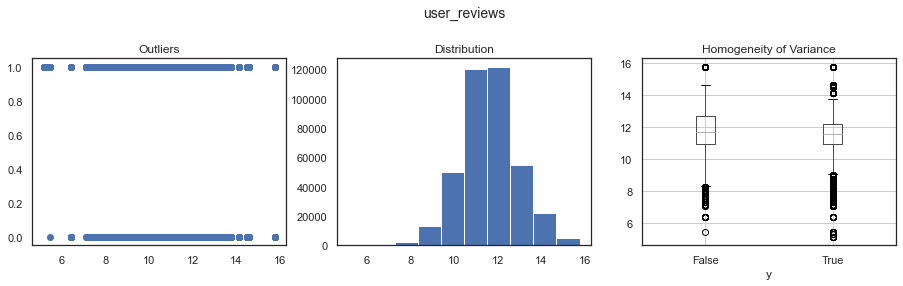

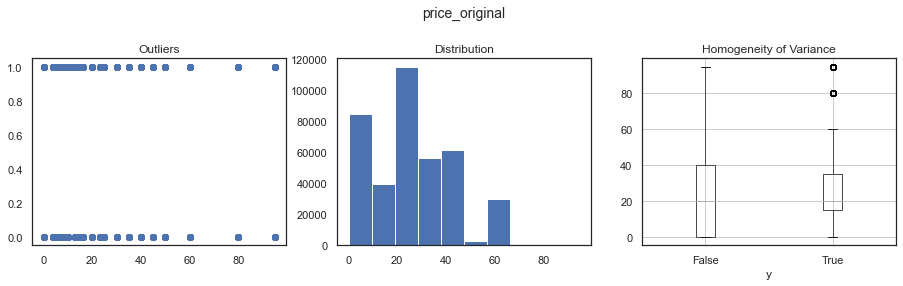

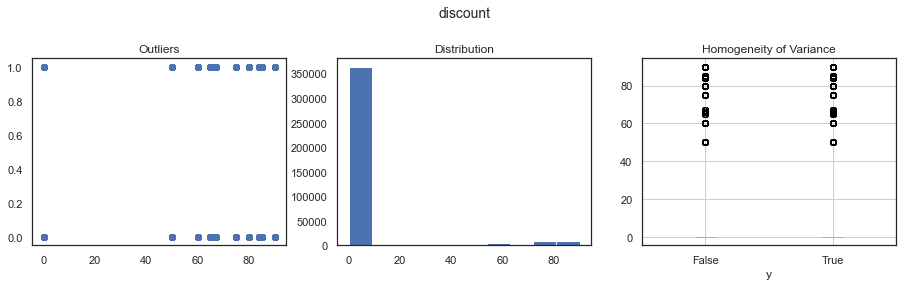

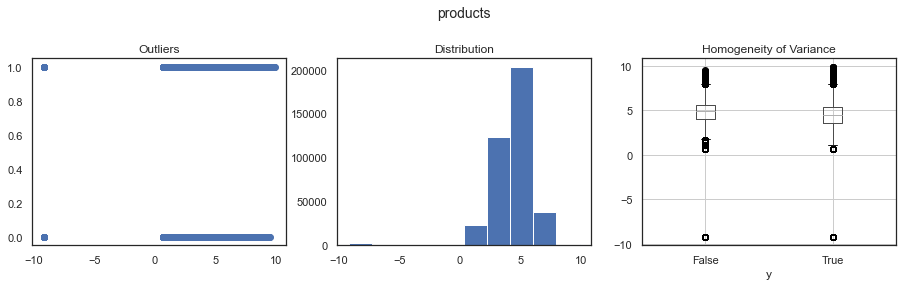

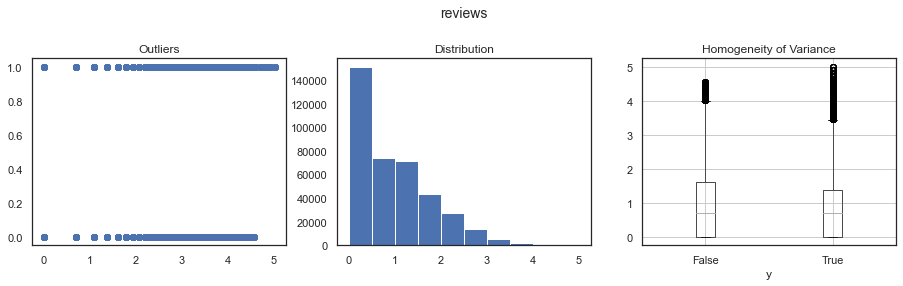

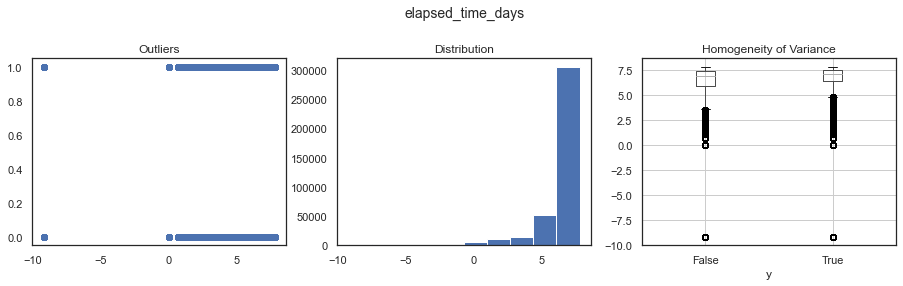

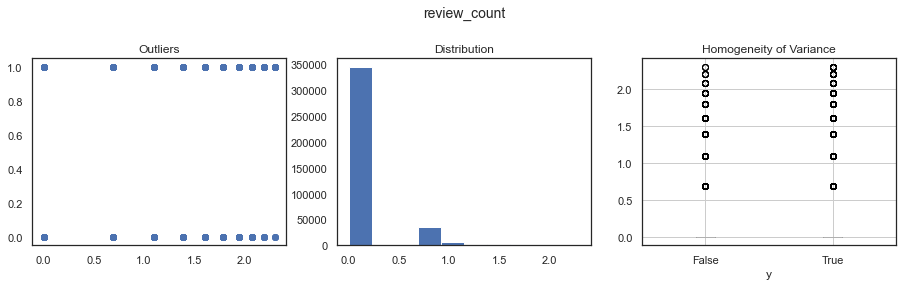

In [46]:
# Check that the normalization made the distributions more similar to normal
check_req(final_df_norm, num_variables)

In [49]:
# Calculate correlation based on the normalized dataset 
cor_matrix = []

for variable in num_variables:
    r_pb, p_value = pointbiserialr(final_df_norm['y'], final_df_norm[variable])
    cor_matrix.append({'Variable name': variable, 'corr': r_pb, 'p-value': p_value})

cor_df = pd.DataFrame(cor_matrix)
cor_df['corr'] = abs(cor_df['corr'])
display(cor_df.sort_values(by="corr", ascending = False))

,Variable name,corr,p-value
1,positive_ratio,0.252644,0.000000e+00
2,hours,0.165955,0.000000e+00
7,products,0.081583,0.000000e+00
9,elapsed_time_days,0.073075,0.000000e+00
8,reviews,0.054118,9.164346e-251
4,user_reviews,0.042056,3.552225e-152
0,price_final,0.038114,2.527854e-125
5,price_original,0.034205,2.666111e-101
10,review_count,0.031532,2.271102e-86
6,discount,0.007416,3.635274e-06


Making the correlation coefficient absolute, we can state the the variables more with a stronger correlation to y are positive_ratio and hours. The ones that follow in the dataset are still correlated (all the p-values are <0.5), but with coefficients lower than 10%.

In any case, we notice that the correlations are not strong across all the variables, with values that don't go over 25%.

#### Binary variables
Phi is a measure for the strength of an association between two categorical variables in a 2 × 2 contingency table. It is calculated by taking the chi-square value, dividing it by the sample size, and then taking the square root of this value. It varies between 0 and 1 without any negative values.

In [50]:
# Define binary variables
bin_variables = ['mac', 'linux']

In [51]:
# Check that they all have two different values
for var in bin_variables: 
    print(var, final_df[var].unique())

mac [False  True]
linux [False  True]


In [52]:
# Calculate their phi value and its p-value
warnings.filterwarnings("ignore", category=FutureWarning)

phi_df = pd.DataFrame(columns=['Variable name', 'corr', 'p-value'])

for var in bin_variables:
    contingency = pd.crosstab(final_df['y'], final_df[var])
    ChiSqResult = chi2_contingency(contingency)
    n = contingency.values.sum()
    phi = np.sqrt(ChiSqResult[0] / n)
    p_value = ChiSqResult[1]
    
    phi_df = phi_df.append({'Variable name': var, 'corr': phi, 'p-value': p_value}, ignore_index=True)

display(phi_df)

,Variable name,corr,p-value
0,mac,0.094448,0.0
1,linux,0.077152,0.0


#### Categorical variables
Cramer's V is an alternative to phi in tables bigger than 2 × 2 tabulation. Cramer's V varies between 0 and 1 without any negative values. Similar to Pearson's r, a value close to 0 means no association. However, a value bigger than 0.25 is named as a very strong relationship for the Cramer's V.

In [53]:
# Define categorical variables
cat_variables = ['rating', 'developer', 'publisher', 'achievements']

In [54]:
# Check that they all have more than two different values
for var in cat_variables: 
    print(var, final_df[var].nunique())

rating 4
developer 251
publisher 197
achievements 114


In [55]:
# calculate Cramer V coefficient for each variable and y
results = []
for var in cat_variables:
    contingency = pd.crosstab(final_df['y'], final_df[var])
    chi2 = chi2_contingency(contingency)[0]
    N = len(final_df)
    minimum_dimension = (min(contingency.shape)-1)
    result = np.sqrt((chi2/N) / minimum_dimension)
    p_value = chi2_contingency(contingency)[1]
    results.append({'Variable name': var, 'corr': result, 'p-value': p_value})

# create dataframe with results
results_df = pd.DataFrame(results).sort_values(by='corr', ascending=False)

display(results_df)

,Variable name,corr,p-value
1,developer,0.286356,0.0
2,publisher,0.272840,0.0
0,rating,0.223368,0.0
3,achievements,0.214983,0.0


# Model Preparation

In the following part, a Logistic Regression model is being used to predict whether a user would like a game or not, which is represented by the binary target variable 'y'. The dataset is first split into features (X) and target (y) and then further split into training and validation sets.

Two versions of the logistic model are created and compared:

The first logistic model uses a limited set of features: 'price_final', 'positive_ratio', 'hours', 'median_playtime'. A preprocessor is created using ColumnTransformer and StandardScaler to standardize these numerical features. A pipeline is created with the preprocessor and a LogisticRegression model with L2 regularization. GridSearchCV is used to optimize the penalty hyperparameter ('C') and regularization type ('penalty') over a range of values, using 10-fold cross-validation and F1 score as the evaluation metric.
The second logistic model adds more features to the first model: 'reviews', 'products', 'discount', 'funny', 'helpful', 'user_reviews', 'price_original', 'required_age', 'achievements'. A new preprocessor is created to standardize these additional numerical features. The same pipeline, grid search, and cross-validation process from the first model is used to optimize the hyperparameters and evaluate the model.
The performance of the second model is compared to the first model to see if adding more features improved the F1 score.

In the third part, Synthetic Minority Over-sampling Technique (SMOTE) is added to the pipeline to address potential class imbalance in the target variable 'y'. A new parameter grid is created to optimize SMOTE's sampling strategy, the number of nearest neighbors, and the logistic regression penalty hyperparameter. Grid search and cross-validation are performed on this pipeline, and the model's performance is compared to the second logistic model to see if adding SMOTE improved the F1 score.
In summary, a logistic regression model is used in this code to predict whether a user would like a game or not based on various features. The model is optimized and compared across different sets of features and with the addition of SMOTE to address class imbalance.

#### Logistic Regression Model

In [ ]:
# Consider balancing out data because of overwhelming positivity
warnings.filterwarnings("ignore")

In [ ]:
print(final_df['y'].value_counts(normalize=True))

In [101]:
# split and prepare data
X = final_df.drop(['y'], axis=1)  # Use all columns except 'y' as features
y = final_df['y']  # Use 'y' as the target variable

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [102]:
# 1. logistic model
num_features_1 = ['price_final', 'positive_ratio', 'hours', 'median_playtime']

preprocessor_1 = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_features_1)])

model_1 = LogisticRegression(penalty='l2', random_state=42)
pipeline_1 = Pipeline(steps=[('preprocessor', preprocessor_1),
                           ('model', model_1)])

# Optimize the penalty hyperparameter
param_grid = {'model__C': [1/10000, 1/1000, 1/100, 1/10, 1, 10, 100, 1000],
              'model__penalty': ['l1', 'l2']}

grid_search_1 = GridSearchCV(pipeline_1, param_grid, cv=10, scoring='f1')
grid_search_1.fit(X_train, y_train)

# Report the average score with the best hyperparameter
print(f"Best average f1: {grid_search_1.best_score_:.8f}")
print(f"Best hyperparameters: {grid_search_1.best_params_}")

Best average f1: 0.91398893
Best hyperparameters: {'model__C': 0.0001, 'model__penalty': 'l2'}


In [103]:
# 2. logistic model with added features
num_features_2 = ['price_final', 'positive_ratio', 'hours', 'median_playtime', 'reviews', 'products', 'discount', 'funny',
                 'helpful', 'user_reviews', 'price_original', 'required_age', 'achievements']

preprocessor_2 = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_features_2)])

model_2 = LogisticRegression(penalty='l2', random_state=42)

pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor_2),
                           ('model', model_2)])


# Optimize the penalty hyperparameter
grid_search_2 = GridSearchCV(pipeline_2, param_grid, cv=10, scoring='f1')
grid_search_2.fit(X_train, y_train)

# Report the average score with the best hyperparameter
print(f"Best average f1: {grid_search_2.best_score_:.8f}")
print(f"Best hyperparameter: {grid_search_2.best_params_}")

# Check if the model performance improved
improved = grid_search_2.best_score_ > grid_search_1.best_score_  
print("\n"f"Model performance improved: {improved}")

Best average f1: 0.91416793
Best hyperparameter: {'model__C': 1, 'model__penalty': 'l2'}

Model performance improved: True


In [104]:
# Define the best model
best_model = LogisticRegression(penalty='l2', random_state=42, C=grid_search_1.best_params_['model__C'])

In [ ]:
# 3. Add SMOTE to the pipeline
smote_param_grid = {
    'smote__sampling_strategy': ['auto', 0.5, 0.75],
    'smote__k_neighbors': [3, 5, 7, 9],
    'smote__n_jobs': [-1]
}

# Combine the SMOTE param_grid with the logistic regression param_grid
param_grid = {
    **smote_param_grid,
    'model__C': [1/10000, 1/1000, 1/100, 1/10, 1, 10, 100, 1000]
}

# Create the pipeline
pipeline_3 = imPipeline(steps=[('preprocessor', preprocessor_2),
                              ('smote', SMOTE(random_state=42)),
                              ('model', best_model)])

# Perform the grid search
grid_search_3 = GridSearchCV(pipeline_3, param_grid, cv=10, scoring='f1')
grid_search_3.fit(X_train, y_train)

# Report the average score with the best hyperparameter
print(f"Best average f1: {grid_search_3.best_score_:.8f}")
print("\n"f"Best hyperparameter: {grid_search_3.best_params_}")

# Check if the model performance improved
improved = grid_search_3.best_score_ > grid_search_2.best_score_  
print("\n"f"Model performance improved: {improved}")

In [ ]:
# Check if the model performance improved
improved = model_3.best_score_ > grid_search_2.best_score_  
print("\n"f"Model performance improved: {improved}")